<h1 style = "font-family: 'Lucida Console', 'Courier New', monospace; background: rgb(44,169,201);
background: linear-gradient(180deg, rgba(44,169,201,1) 0%, rgba(1,94,125,1) 100%); border-radius: 20px; font-size:30px; text-align:center; ">Import Libraries 📚</h1>

In [1]:
import os
from tqdm import tqdm
from colorama import Fore, Back, Style

import numpy as np
import pandas as pd

import wordcloud
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

import warnings
warnings.filterwarnings('ignore')

<h1 style = "font-family: 'Lucida Console', 'Courier New', monospace; background: rgb(44,169,201);
background: linear-gradient(180deg, rgba(44,169,201,1) 0%, rgba(1,94,125,1) 100%); border-radius: 20px; font-size:30px; text-align:center; ">Initialize Constants 🔰</h1>

In [2]:
train_label_df = pd.read_csv("../data/train_labels.csv")
train_essay_df = pd.read_csv("../data/train_essay.csv")
train_ids = list(train_essay_df["id"])
num_rows = len(train_label_df)

classes = ["Claim", "Evidence", "Position", "Concluding Statement", "Lead", "Counterclaim", "Rebuttal", "None"]
crma = {
    classes[0] : Fore.BLUE,
    classes[1] : Fore.RED,
    classes[2] : Fore.MAGENTA,
    classes[3] : Fore.YELLOW,
    classes[4] : Fore.GREEN,
    classes[5] : Fore.WHITE,
    classes[6] : Fore.CYAN,
    classes[7] : Fore.LIGHTBLUE_EX
}
sr_crma = Style.RESET_ALL

train_label_df.drop("fold_label", axis=1, inplace=True)
train_label_df.head(2)

id  discourse_id  discourse_start  discourse_end  \
0  423A1CA112E2  1.622630e+12                8            229   
1  423A1CA112E2  1.622630e+12              230            312   

                                      discourse_text discourse_type  \
0  Modern humans today are always on their phone....           Lead   
1  They are some really bad consequences when stu...       Position   

  discourse_type_num                                   predictionstring  
0             Lead 1  1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 1...  
1         Position 1       45 46 47 48 49 50 51 52 53 54 55 56 57 58 59

<h1 style = "font-family: 'Lucida Console', 'Courier New', monospace; background: rgb(44,169,201);
background: linear-gradient(180deg, rgba(44,169,201,1) 0%, rgba(1,94,125,1) 100%); border-radius: 20px; font-size:30px; text-align:center; "> Data Preprocessing ⚒️🔬</h1>

<h2 style = "font-family: 'Lucida Console', 'Courier New', monospace; border-radius: 20px; font-size:30px; text-align:center; ; color:#FF69B4">Necessary Functions</h2>

In [3]:
def get_row(text, df, pos, count):
    row_curr, row_next = df.iloc[pos], df.iloc[pos+1]
    txt_id, discourse_id = row_curr.id, row_curr.discourse_id
    
    if pos == 0 and row_curr.discourse_start!=0:
        start, end = 0, int(row_curr.discourse_start)
        start_word, end_word = 0, int(row_curr.predictionstring.split(" ")[-1])
    elif pos == len(df)-1 and row_curr.discourse_end!=len(text):
        start, end = int(row_curr.discourse_end), len(text)
        start_word, end_word = int(row_curr.predictionstring.split(" ")[-1])+1, len(text.split(" "))-1
    else:
        start, end = int(row_curr.discourse_end), int(row_next.discourse_start)
        start_word = int(row_curr.predictionstring.split(" ")[-1])+1
        end_word = int(row_next.predictionstring.split(" ")[0])
    
    pred_str = [str(start_word+i) for i in range(end_word-start_word)] 
    pred_str = " ".join(pred_str)
    discourse_text = text[start:end]
    return [
            txt_id,discourse_id,
            start, end,
            discourse_text,
            "None", "None " + str(count),
            pred_str
           ]

In [4]:
##-----------------------------------------------
#Getting list of text that is missing in csv file
##-----------------------------------------------
none_ls = []
for txt_id in tqdm(train_ids):
    df = train_label_df[train_label_df["id"] == txt_id]
    text = train_essay_df[train_essay_df["id"] == id]["text"]
    count = 0
    
    for i in range(len(df)-1):
        row_i0, row_i1 = df.iloc[i], df.iloc[i+1]
        if row_i1.discourse_start > row_i0.discourse_end+1:
            none_ls.append(get_row(text, df, i, count))
            count += 1
            
        if row_i1.discourse_end < len(text) and i == len(df)-1:
            start, end = int(row_i1.predictionstring.split(" ")[-1])+1, len(text.split(" "))
            pred_str = [str(start+i) for i in range(end-start)] 
            pred_str = " ".join(pred_str)
            none_ls.append([
                row_i1.id, row_i1.discourse_id,
                row_i1.discourse_end, len(text),
                text[int(row_i1.discourse_end):len(text)],
                "None", "None "+str(count),
                pred_str
            ])

100%|██████████| 15592/15592 [04:30<00:00, 57.54it/s]


In [5]:
##---------------------------------------
#Adding text with None class to DataFrame
##---------------------------------------
none_df = pd.DataFrame(none_ls,columns=list(train_label_df.columns))
none_df.head()

df = pd.concat([train_label_df,none_df])
df = df.sort_values(by=["id","discourse_start"],ascending=[True,True]).reset_index(drop=True)
df.tail(3)

id  discourse_id  discourse_start  discourse_end  \
169270  FFFD0AF13501  1.619820e+12              959           1050   
169271  FFFD0AF13501  1.619820e+12             1051           1245   
169272  FFFF80B8CC2F  1.617040e+12                0            990   

                                           discourse_text  \
169270  all i'm saying is that the seagoing cowboys wo...   
169271  You can go so many places and you rarely go to...   
169272  Venus is a planet what belong the System Solar...   

              discourse_type      discourse_type_num  \
169270              Position              Position 1   
169271  Concluding Statement  Concluding Statement 1   
169272              Evidence              Evidence 1   

                                         predictionstring  
169270  193 194 195 196 197 198 199 200 201 202 203 20...  
169271  209 210 211 212 213 214 215 216 217 218 219 22...  
169272  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18...

In [6]:
##------------------------------------
#Print a discourse coloured by classes
##------------------------------------
for cls in classes:
    print(f"{crma[cls]} {cls} {sr_crma} ", end=" ")

print("\n\n")
tmp_df = df[df["id"] == train_ids[7]]
for i in range(len(tmp_df)):
    row = tmp_df.iloc[i]
    print(f"{crma[row.discourse_type]}{row.discourse_text}{sr_crma}", end=" ")

 Claim    Evidence    Position    Concluding Statement    Lead    Counterclaim    Rebuttal    None   


It is every student's dream to be able to lounge around at home, and complete school from the comforts of their own beds. Though, for some students, this long desired fantasy is becoming a reality. With the introduction of new and innovative technologies into the classroom, distance learning is now a common practice, whether it be online or through video conferencing. However, to pretend that this is a solution to the ever-growing problems within the education system, is willfully ignorant  Distance education is actually detrimental to the students who choose to take these courses, due to the lack of typical classroom structure.  Everybody knows somebody like this in their lives; a homebody, someone who prefers staying home over going out, maybe doesn't have too many friends or has trouble forging bonds and building relationships. You may also call these people recluses, or shut-ins,

In [7]:
##----------------------
#Distribution of classes
##----------------------

classes_count = [list(df["discourse_type"]).count(i) for i in classes]

fig = px.bar(x = classes, y = classes_count, color = classes,color_continuous_scale="Emrld") 
fig.update_xaxes(title="Classes")
fig.update_yaxes(title = "Count")
fig.update_layout(showlegend = True,
    title = {
        'text': 'Discourse Class Distribution [#Tokens]',
        'y':0.95,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
fig.show()

In [28]:
##-----------------------
#Length of Text and Words
##-----------------------
text_length, word_length = {}, {}

for id, row in tqdm(train_essay_df.iterrows()):
    txt = row["text"]
    text_length[row["id"]] = len(txt)
    word_length[row["id"]] = len(txt.split(" "))
    
df = df[df["id"].isin(train_essay_df["id"])]
df["text_length"] = df["id"].map(lambda x : text_length[x])
df["word_length"] = df["id"].map(lambda x : word_length[x])

404it [00:00, 4029.63it/s]

15592it [00:02, 5463.49it/s]


In [29]:
fig = make_subplots(rows=1, cols=2)

fig.add_trace(
    go.Histogram(x=list(text_length.values()), name="Length of text"),
    row=1, col=1
)

fig.add_trace(
    go.Histogram(x=list(word_length.values()), name="Number of words"),
    row=1, col=2
)

fig.update_layout(height=500, width=1000, title_text="Histogram of length of text and number of words")
fig.show()

In [17]:
##-------------------------------------------------
#Distribution of each class in different discourses
##-------------------------------------------------
count_dict = {
    classes[0] : [],
    classes[1] : [],
    classes[2] : [],
    classes[3] : [],
    classes[4] : [],
    classes[5] : [],
    classes[6] : [],
    classes[7] : []
}

for txt_id in tqdm(train_ids):
    tmp = df[df["id"] == txt_id]
    for c in classes:
        count_dict[c].append(len(tmp[tmp["discourse_type"] == c]))

100%|██████████| 15592/15592 [04:20<00:00, 59.91it/s]


In [18]:
fig = make_subplots(rows=4, cols=2, start_cell="bottom-left")
r = [1,1,2,2,3,3,4,4]
c = [1,2,1,2,1,2,1,2]

for i,cls in enumerate(classes):
    fig.add_trace(go.Histogram(x=count_dict[cls], name=cls),row=r[i], col=c[i])

fig.update_layout(height=800, width=900, title_text="Distribution of each class in training data")
fig.show()

In [74]:
##--------------------------------
#Information of each class in text
##--------------------------------
start, end, length, words = {}, {}, {}, {}

for cls in classes:
    tmp = df[df["discourse_type"] == cls]
    
    tmp["count"] = tmp["predictionstring"].map(lambda x : len(x.split(" ")))
    start[cls] = np.array(tmp["discourse_start"])/np.array(tmp["text_length"])
    end[cls] = np.array(tmp["discourse_end"])/np.array(tmp["text_length"])
    length[cls] = np.array(tmp["discourse_end"] - tmp["discourse_start"] + 1)/np.array(tmp["text_length"])
    words[cls] = np.array(tmp["count"])#/np.array(tmp["text_length"])

In [76]:
##--------------------------------
#Start, End position of each Class
##--------------------------------

fig = make_subplots(rows=4, cols=2, subplot_titles=classes)

for i,cls in enumerate(classes):
    fig.add_trace(go.Box(x=end[cls], name="end"),row=r[i], col=c[i])
    fig.add_trace(go.Box(x=start[cls], name="start"),row=r[i], col=c[i])
    
fig.update_layout(height=800, width=900, showlegend=False, title_x=0.5,  title_text="Start, End Position of text [Normalized]")

fig.show()

In [49]:
##----------------------------
#Length of text per each Class
##----------------------------

fig = make_subplots(rows=4, cols=2, subplot_titles=classes)

for i,cls in enumerate(classes):
    fig.add_trace(go.Box(x=length[cls]),row=r[i], col=c[i])
    
fig.update_layout(height=800, width=900, showlegend=False, title_x=0.5, title_text="Text length Distribution [Normalized]")
fig.update_yaxes(showticklabels=False)
fig.show()

In [53]:
##-------------------------------------
#Number of words in text per each Class
##-------------------------------------

fig = make_subplots(rows=4, cols=2, subplot_titles=classes)

for i,cls in enumerate(classes):
    fig.add_trace(go.Box(x=words[cls]),row=r[i], col=c[i])
    
fig.update_layout(height=800, width=900, showlegend=False, title_x=0.5, title_text="#Tokens Distribution")
fig.update_yaxes(showticklabels=False)
fig.show()

<h2 style = "font-family: 'Lucida Console', 'Courier New', monospace; border-radius: 20px; font-size:30px; text-align:center; ; color:#FF69B4">Word Cloud</h2>

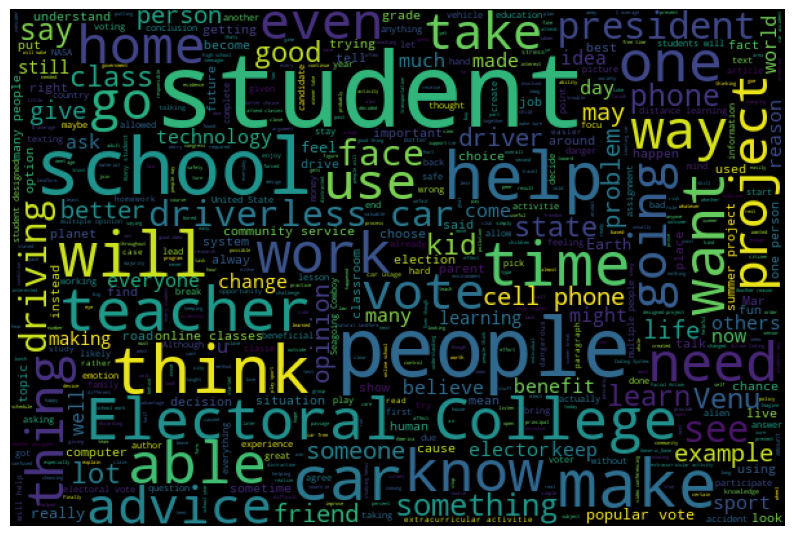

In [67]:
wcloud = wordcloud.WordCloud(stopwords=wordcloud.STOPWORDS, max_font_size=80, max_words=6000,
                      width = 600, height = 400,
                      background_color='black').generate(' '.join([txt for txt in df["discourse_text"].values if type(txt)==str]))

fig, ax = plt.subplots(figsize=(10,10))
ax.imshow(wcloud, interpolation='bilinear')
ax.set_axis_off()
plt.imshow(wcloud)